## 1. Import


In [1]:
# Importing the libraries

# Libraries for data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for logging the mlflow runs
import mlflow
from mlflow.models import infer_signature

# Libraries for splliting the data and building machine learning models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import tree
from sklearn.dummy import DummyClassifier


# necessary classifiers for building machine learning models
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load the data
df = pd.read_csv('../data/apple_quality.csv', sep=',', header=0)
df = df.drop(columns=['A_id'])
# Split the data into X and y for the model
X = df.drop(columns=['Quality'])
y = df['Quality'].replace({'bad': 0, 'good': 1})  # convert the target variable to binary good=1, bad=0

C:\Users\timon\AppData\Local\Temp\ipykernel_23436\2539685662.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Quality'].replace({'bad': 0, 'good': 1})  # convert the target variable to binary good=1, bad=0


## 2. Datensichtung

In [3]:
# Exploratory Data Analysis

# 1 Overall Overviwew
print('Head: \n',df.head())
# 2 Data Summary
print('\nSize: \n',df.shape)
# 3 Data Info
print('\nData Info: \n')
print(df.info())
# 4 Data Description
print('\nData Description: \n')
print(df.describe())
# 5 Missing Values
print('\nMissing Values: \n')
print(df.isnull().sum())

# Correlation Matrix
df_corr = df.drop(columns=['Quality'])
#correlation_matrix = df_corr.corr()
#print('\nCorrelation Matrix: \n')
#print(correlation_matrix)

# Quelle
# (5) https://www.kdnuggets.com/7-essential-data-quality-checks-with-pandas

Head: 
        Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840 -0.491590   
1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530 -0.722809   
2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033  2.621636   
3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  0.790723   
4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849  0.501984   

  Quality  
0    good  
1    good  
2     bad  
3    good  
4    good  

Size: 
 (4000, 8)

Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   R

### 2.1 Visualisierung der Daten

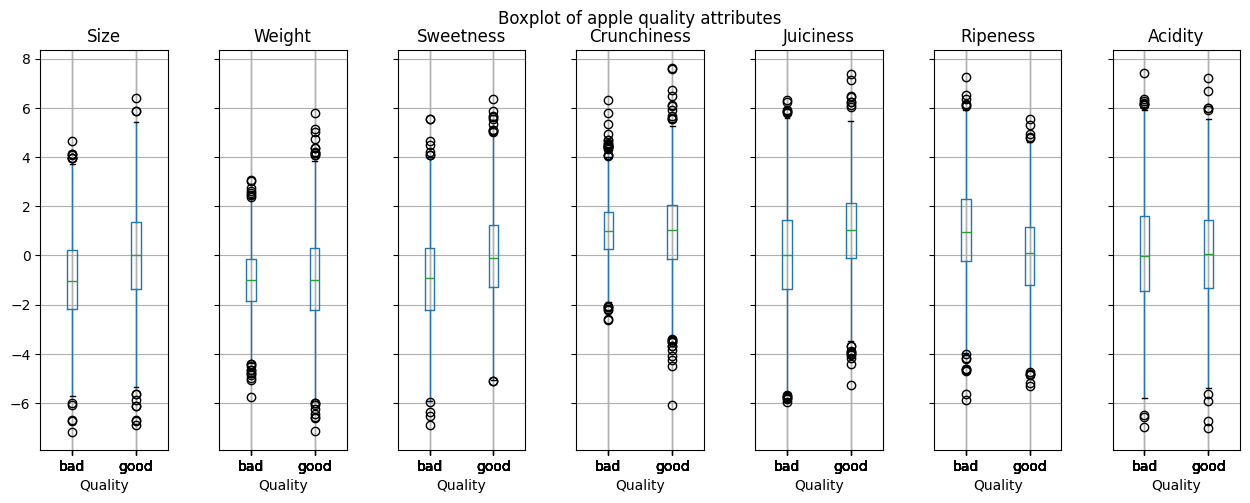

In [4]:
# Boxplot of apple quality attributes in relation to the quality
colors = ['lightblue', 'orange']
df.boxplot(column=['Size', 
                   'Weight', 
                   'Sweetness', 
                   'Crunchiness', 
                   'Juiciness', 
                   'Ripeness', 
                   'Acidity'], 
           by='Quality', 
           layout=(1, 7), 
           figsize=(15, 5))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

plt.suptitle('Boxplot of apple quality attributes')

plt.show()

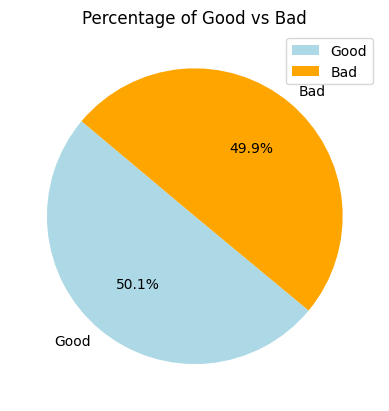

In [5]:
# Calculate the sum of "good" and "bad" values
good_count = df[df['Quality'] == 'good'].shape[0]
bad_count = df[df['Quality'] == 'bad'].shape[0]
total_count = good_count + bad_count

# Calculate percentages
good_percentage = good_count / total_count * 100
bad_percentage = bad_count / total_count * 100

# Create a pie chart
labels = ['Good', 'Bad']
sizes = [good_percentage, bad_percentage]
colors = ['lightblue', 'orange']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title and legend
plt.title('Percentage of Good vs Bad')
plt.legend(labels, loc="best")

# Display the chart
plt.show()

<Axes: >

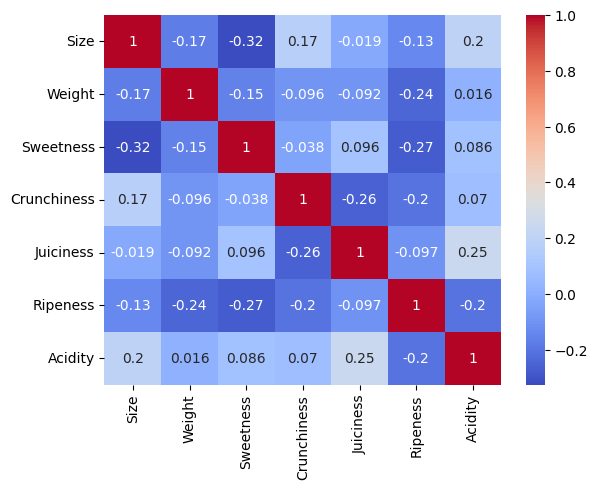

In [6]:
# Create a heatmap of the correlation matrix
sns.heatmap(df_corr.corr(),annot=True,cmap='coolwarm')

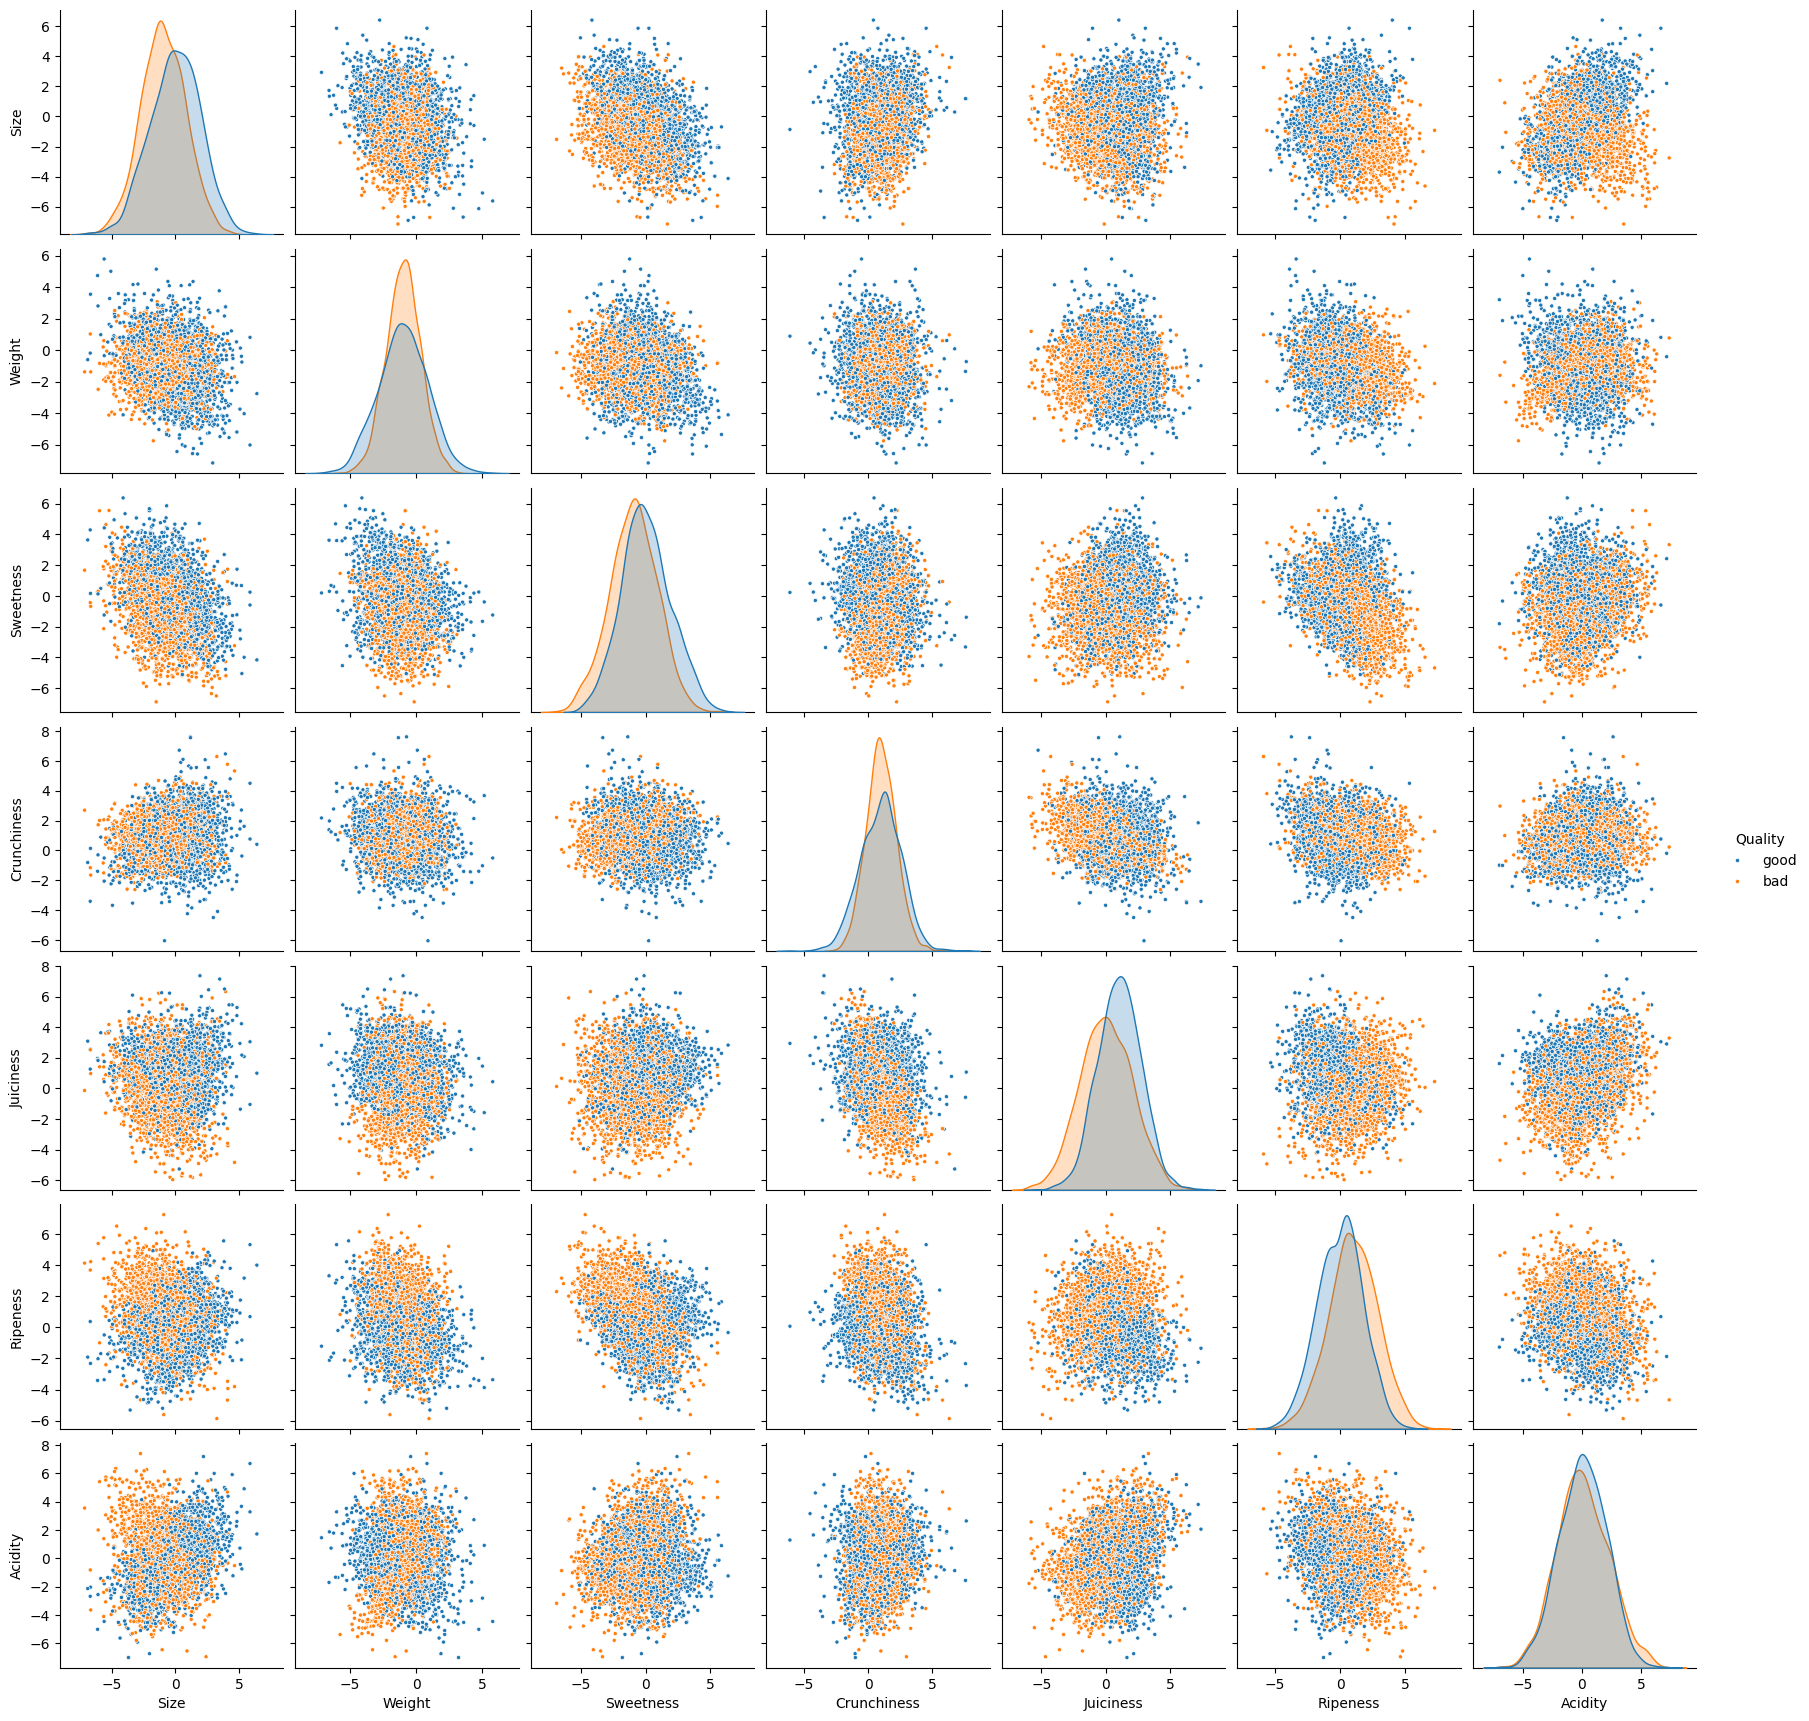

In [7]:
# Pairplot
sns.pairplot(df, hue='Quality', markers=[".", "."])

### 2.2 Feature Engineering

In [8]:
# Desicion Tree
cols = df.columns[0:7]

clf1 = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
clf1.fit(df[cols], df['Quality'])

DecisionTreeClassifier(max_depth=5, random_state=42)

In [9]:
# make sklearn classification report
y_pred = clf1.predict(df[cols])
print(classification_report(df['Quality'], y_pred, target_names=df['Quality'].unique()))

              precision    recall  f1-score   support

        good       0.73      0.85      0.78      1996
         bad       0.82      0.68      0.74      2004

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.76      4000
weighted avg       0.77      0.77      0.76      4000



In [10]:
# print importance of features
for i in range(len(cols)):
    print("{}\t{:.2f}".format(cols[i], clf1.feature_importances_[i]))
    # print("{}\t{:.2f}".format(cols[1], clf1.feature_importances_[1]))

Size	0.22
Weight	0.11
Sweetness	0.13
Crunchiness	0.01
Juiciness	0.19
Ripeness	0.20
Acidity	0.13


### 2.3 Datensatz Split

In [11]:
# Split the data into training (3200), validation (640), and test (160) sets
x_train, x_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.2, random_state=0)

In [12]:
x_train.shape, x_val.shape, x_test.shape

((3200, 7), (640, 7), (160, 7))

## 3 Machine Learning

In [13]:
# Model Building, function collection

def model(classifier,x_train:pd.DataFrame,y_train:pd.DataFrame,x_test:pd.DataFrame,y_test:pd.DataFrame):
    """Defining a function to train and evaluate a machine learning classifier model
    Args:
        classifier (XGBClassifier): Object of the classifier
        x_train (pd.DataFrame): Training data
        y_train (pd.DataFrame): Training metadata
        x_test (pd.DataFrame): Testing data
        y_test (pd.DataFrame): Testing metadata

    Returns:
        array: Model prediction
    """
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    return prediction

def model_evaluation(classifier,x_test:pd.DataFrame,y_test:pd.DataFrame):
    """
    Defining a function to evaluate the performance of a machine learning classifier model
    Args:
        classifier (XGBClassifier): Object of the classifier
        x_test (pd.DataFrame): Testing data
        y_test (pd.DataFrame): Testing metadata
    """
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')

    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

def plot_roc_curve(y_true, y_scores):
    """
    Defining a function to plot the Receiver Operating Characteristic (ROC) curve
    Args:
        y_true (pd.DataFrame): True labels
        y_scores (pd.DataFrame): Predicted scores
    """
    
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Calculate the area under the ROC curve (AUC)
    auc = roc_auc_score(y_true, y_scores)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## XGBoost-Classifier

In [14]:
# Hyperparameter tuning for the XGBoost classifier
xgb_tuner = XGBClassifier()

param_grid = {
    'learning_rate': [0.01],
    'max_depth': [11],
    'n_estimators': [1500],
    'random_state': [0],
    'min_split_loss': [0],
    'min_child_weight': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
}

grid_search = GridSearchCV(estimator=xgb_tuner, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

# Perform the grid search
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding ROC AUC score
print("Best hyperparameters: ", grid_search.best_params_)

print("Best ROC AUC score: ", grid_search.best_score_)

Best hyperparameters:  {'learning_rate': 0.01, 'max_depth': 11, 'min_child_weight': 0.5, 'min_split_loss': 0, 'n_estimators': 1500, 'random_state': 0, 'reg_alpha': 0.5, 'reg_lambda': 1}
Best ROC AUC score:  0.9538338602579047


In [15]:
# Initializing an XGBoost classifier with specific hyperparameters
learnig_rate = 0.01
max_depth = 11
n_estimators = 1500
random_state = 0
min_split_loss = 0
min_child_weight = 0.5
reg_lambda = 1
reg_alpha = 0.5
tree_method = 'exact'

classifier_xgb = XGBClassifier(learning_rate= learnig_rate, 
                               max_depth = max_depth, 
                               n_estimators = n_estimators, 
                               device = 'cpu', 
                               random_state = random_state,
                               min_split_loss = min_split_loss,
                               min_child_weight = min_child_weight,
                               reg_lambda = reg_lambda,
                               reg_alpha = reg_alpha)

Erklärungen zu den Hyperparametern:

- **learnig_rate**: Dieser Parameter steuert die Lernrate des Gradientenabstiegs. Eine niedrige Lernrate macht das Modell konservativer, da die Aktualisierungen der Modellgewichte kleiner sind.

- **max_depth**: Dies ist die maximale Tiefe der einzelnen Bäume im Modell. Wenn dieser Wert erhöht wird, wird das Modell komplexer, da es tiefere Entscheidungsbäume zulässt.

- **n_estimators**: Dies gibt an, wie viele Bäume im Modell verwendet werden sollen.

- **random_state**: Dieser Parameter wird verwendet, um die Randomisierung zu steuern, um sicherzustellen, dass die Ergebnisse reproduzierbar sind.

- **min_split_loss**: Wenn dieser Wert erhöht wird, wird das Modell konservativer, da die Mindestverluständerung erforderlich ist, um einen Knoten zu teilen.

- **min_child_weight**: Dieser Parameter definiert das minimale Gewicht, das ein Blattknoten haben muss, um weiter in Betracht gezogen zu werden.

- **reg_lambda**: Dies ist der Regularisierungsterm für L2-Regularisierung. Ein höherer Wert macht das Modell konservativer, da die Regularisierung stärker ist.

- **reg_alpha**: Dies ist der Regularisierungsterm für L1-Regularisierung. Ein höherer Wert macht das Modell konservativer, da die Regularisierung stärker ist.

- **tree_method**: Dieser Parameter steuert, welcher Algorithmus zur Konstruktion von Entscheidungsbäumen verwendet wird. Die Optionen sind 'auto', 'exact', 'approx' und 'hist'.

Cross Validation Score :  96.05%
ROC_AUC Score :  89.71%
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       347
           1       0.86      0.92      0.89       293

    accuracy                           0.90       640
   macro avg       0.89      0.90      0.89       640
weighted avg       0.90      0.90      0.90       640



'# Log the hyperparameters and the performance metrics\nmlflow.log_param(\'learning_rate\', learnig_rate)\nmlflow.log_param(\'max_depth\', max_depth)\nmlflow.log_param(\'n_estimators\', n_estimators)\nmlflow.log_param(\'device\', \'cpu\')\nmlflow.log_param(\'random_state\', random_state)\nmlflow.log_param(\'min_split_loss\', min_split_loss)\nmlflow.log_param(\'min_child_weight\', min_child_weight)\nmlflow.log_param(\'reg_lambda\', reg_lambda)\nmlflow.log_param(\'reg_alpha\', reg_alpha)\nmlflow.log_param(\'tree_method\', tree_method)\nmlflow.log_metric(\'accuracy\', accuracy)\n\nmlflow.sklearn.log_model(\n        sk_model=classifier_xgb,\n        artifact_path="sklearn-model",\n        signature=signature,\n        registered_model_name="XGBBoost_Apple_Quality_small_dataset",\n    )\n\n# End MLflow run \nmlflow.end_run()'

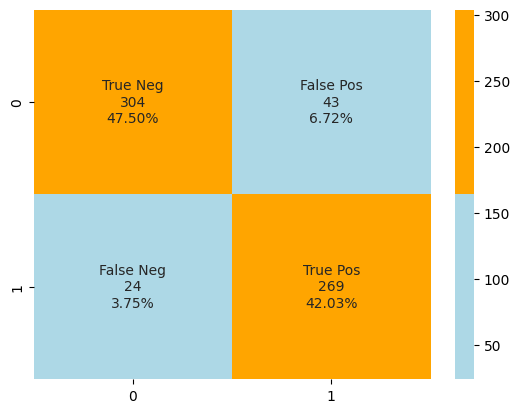

In [16]:
"""# Start tracking
mlflow.set_tracking_uri('http://localhost:8080')
mlflow.set_experiment('XGBoost_Classifier_Apple_Quality')
mlflow.start_run()"""

# Training, evaluating, and evaluating the performance of an XGBoost classifier model

y_val_pred = model(classifier_xgb,x_train,y_train,x_val,y_val)
model_evaluation(classifier_xgb,x_val,y_val)

accuracy = accuracy_score(y_val, y_val_pred)
signature = infer_signature(x_test, y_val_pred)
# model_evaluation(classifier_xgb,x_test,y_test)

"""# Log the hyperparameters and the performance metrics
mlflow.log_param('learning_rate', learnig_rate)
mlflow.log_param('max_depth', max_depth)
mlflow.log_param('n_estimators', n_estimators)
mlflow.log_param('device', 'cpu')
mlflow.log_param('random_state', random_state)
mlflow.log_param('min_split_loss', min_split_loss)
mlflow.log_param('min_child_weight', min_child_weight)
mlflow.log_param('reg_lambda', reg_lambda)
mlflow.log_param('reg_alpha', reg_alpha)
mlflow.log_param('tree_method', tree_method)
mlflow.log_metric('accuracy', accuracy)

mlflow.sklearn.log_model(
        sk_model=classifier_xgb,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="XGBBoost_Apple_Quality_small_dataset",
    )

# End MLflow run 
mlflow.end_run()"""

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        75
           1       0.85      0.89      0.87        85

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



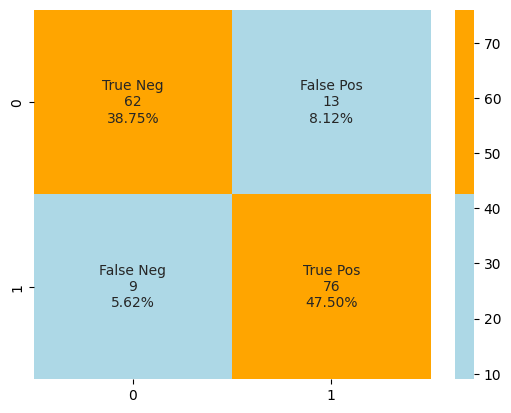

In [17]:
# Model evaluation on the test set
model_evaluation(classifier_xgb,x_test,y_test)

In [18]:
# print importance of features
for i in range(len(cols)):
    print("{}\t{:.2f}".format(cols[i], classifier_xgb.feature_importances_[i]))

Size	0.18
Weight	0.11
Sweetness	0.15
Crunchiness	0.11
Juiciness	0.16
Ripeness	0.16
Acidity	0.13


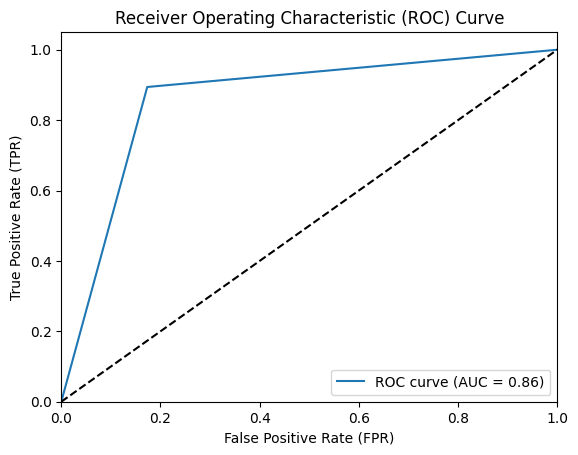

In [19]:
# Plot the ROC curve
prediction_xgb = classifier_xgb.predict(x_test)
plot_roc_curve(y_test, prediction_xgb)

## KNN-Classifier

### Dummy Classifier

In [20]:
# Create and train dummy classifiers 
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(x_train, y_train)

# Make predictions
y_pred = dummy_clf.predict(x_test)

# Genauigkeit auswerten
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Dummy Classifier: {accuracy}")

Accuracy of Dummy Classifier: 0.53125


In [ ]:
knn_test = KNeighborsClassifier()

model(knn_test,x_train,y_train,x_val,y_val)
model_evaluation(knn_test,x_val,y_val)

### Hyperparametertuning

In [20]:
# Hyperparameter tuning for the KNN classifier using GridSearchCV
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'leaf_size': [1,2,3,4,5,10, 20, 30, 40, 50],
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='roc_auc', cv=10, n_jobs=-1, refit='recall_score')

# Perform the grid search
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding ROC AUC score
print("Best hyperparameters: ", grid_search.best_params_)

print("Best ROC AUC score: ", grid_search.best_score_)

grid_mean_scores = grid_search.cv_results_['mean_test_score']
print("ROC AUC score evolution: ",grid_mean_scores)

Best hyperparameters:  {'leaf_size': 1, 'n_neighbors': 15}
Best ROC AUC score:  0.9601417522583748
ROC AUC score evolution:  [0.8804835  0.93981766 0.9507855  0.95592176 0.95692984 0.95949696
 0.95930555 0.96014175 0.9599347  0.95928996 0.8804835  0.93981766
 0.9507855  0.95592176 0.95692984 0.95949696 0.95930555 0.96014175
 0.9599347  0.95928996 0.8804835  0.93981766 0.9507855  0.95592176
 0.95692984 0.95949696 0.95930555 0.96014175 0.9599347  0.95928996
 0.8804835  0.93981766 0.9507855  0.95592176 0.95692984 0.95949696
 0.95930555 0.96014175 0.9599347  0.95928996 0.8804835  0.93981766
 0.9507855  0.95592176 0.95692984 0.95949696 0.95930555 0.96014175
 0.9599347  0.95928996 0.8804835  0.93981766 0.9507855  0.95592176
 0.95692984 0.95949696 0.95930555 0.96014175 0.9599347  0.95928996
 0.8804835  0.93981766 0.9507855  0.95592176 0.95692984 0.95949696
 0.95930555 0.96014175 0.9599347  0.95928996 0.8804835  0.93981766
 0.9507855  0.95592176 0.95692984 0.95949696 0.95930555 0.96014175
 0.9

In [40]:
# Generate a list of hyperparameters for plotting
kNN_list = []
for i in param_grid['n_neighbors']:
    for j in param_grid['leaf_size']:
        kNN_list.append(f"k= {i} / l= {j}")

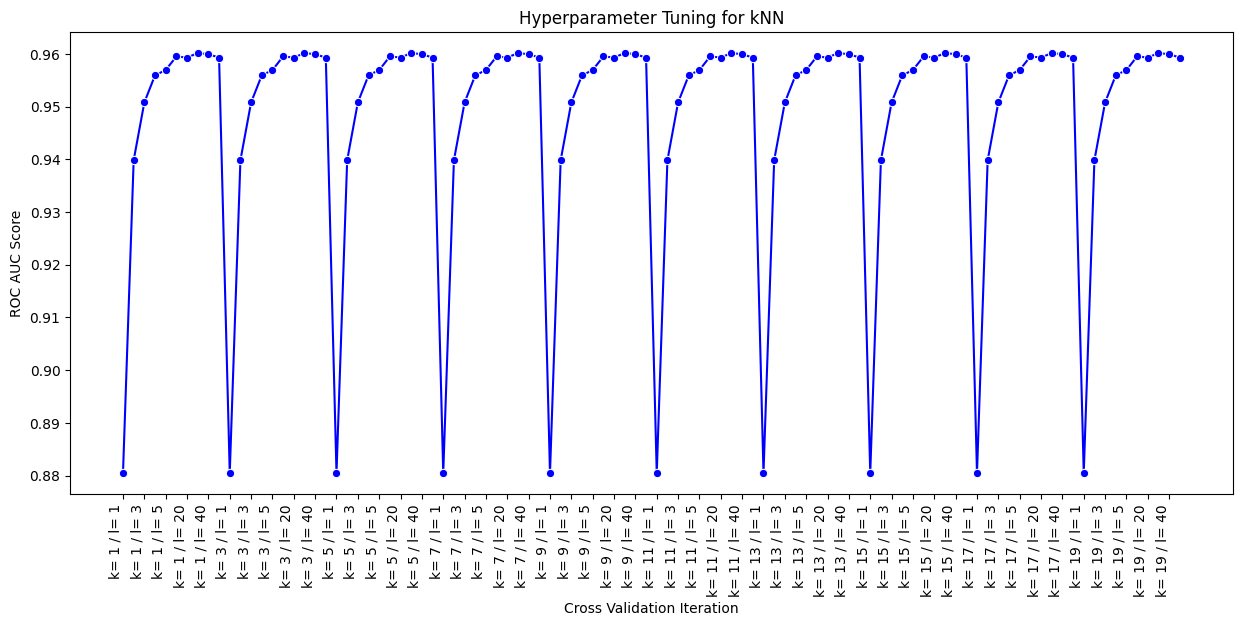

In [43]:
# Creates Seaborn Plot for Hyperparameter Tuning
# X-Axis: Cross Validation Iteration labeled with the hyperparameters steps = 2
# Y-Axis: ROC AUC Score
plt.figure(figsize=(15, 6))
sns.lineplot(x=kNN_list, y=grid_mean_scores, marker='o', color='blue')
plt.xticks(rotation=90, ha='right')
plt.title('Hyperparameter Tuning for kNN')
plt.xlabel('Cross Validation Iteration')
plt.ylabel('ROC AUC Score')
plt.xticks(kNN_list[::2])

plt.show()

### Validierung

Cross Validation Score :  96.26%
ROC_AUC Score :  90.68%
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       347
           1       0.87      0.93      0.90       293

    accuracy                           0.90       640
   macro avg       0.90      0.91      0.90       640
weighted avg       0.91      0.90      0.90       640



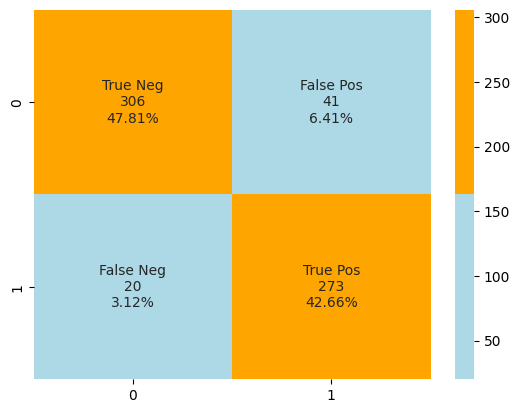

In [19]:
# Initializing a K-Nearest Neighbors classifier with specific hyperparameters
k_nn = KNeighborsClassifier(n_neighbors=15, leaf_size=1, weights='distance', metric='euclidean')

model(k_nn,x_train,y_train,x_val,y_val)
model_evaluation(k_nn,x_val,y_val)

### Test

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        75
           1       0.87      0.87      0.87        85

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



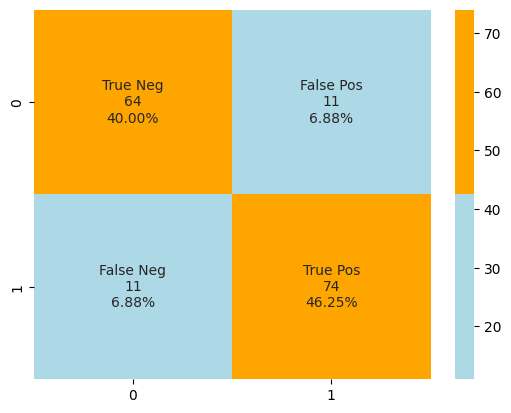

In [20]:
# Modell Evaluation on the test data
model_evaluation(k_nn,x_test,y_test)